### Fashion MNIST CNN
#### Image augmentation(이미지 증강) 추가

In [2]:
# coding: utf-8

import sys 
import os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
np.random.seed(121)
tf.random.set_seed(121)

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [6]:
print(train_images.shape) # 0에서 255 사이의 값을 갖는 28X28 크기의 numpy array
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [7]:
print(train_labels.shape) # 0에서 9까지의 정수 값을 갖는 array
print(test_labels.shape)

(60000,)
(10000,)


In [8]:
print(train_labels[:10])
print(test_labels[:10])

[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


In [9]:
set(train_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [10]:
NUM_CLASSES__ = len(set(train_labels))
NUM_CLASSES__

10

In [11]:
LABEL_NAME__ = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']

#### 공통함수

In [12]:
def myPlot(fit_res) :
    key_ = list(fit_res.history.keys())
    plt.figure(figsize=(12,5))
    for i in range(len(key_)):
        plt.plot(fit_res.history[key_[i]], label=key_[i])
    plt.title("metrics")
    plt.xlabel("epoch")
    plt.ylabel("score")
    plt.legend()
    plt.show()

In [13]:
def myscore(X,y,fit_res=None):
    # test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=1)
    # print(f"loss: {test_loss:.5f} accuracy: {test_acc:.5f}" )
    history = model.evaluate(X,  y, verbose=1)
    print(f"loss: {history[0]:.5f} accuracy: {history[1]:.5f}" )
    if fit_res != None:
        myPlot(fit_res)
# myscore(test_images,  test_labels, fit_res)

In [14]:
def mypredit_check(test_X, idx=0):
    pred = model.predict(test_X)
    print(pred[idx])
    pred_label = np.argmax(pred[idx])
    print(pred_label, LABEL_NAME__[pred_label])
    plt.imshow(test_X[idx])
    plt.show()

#### visualization sample image

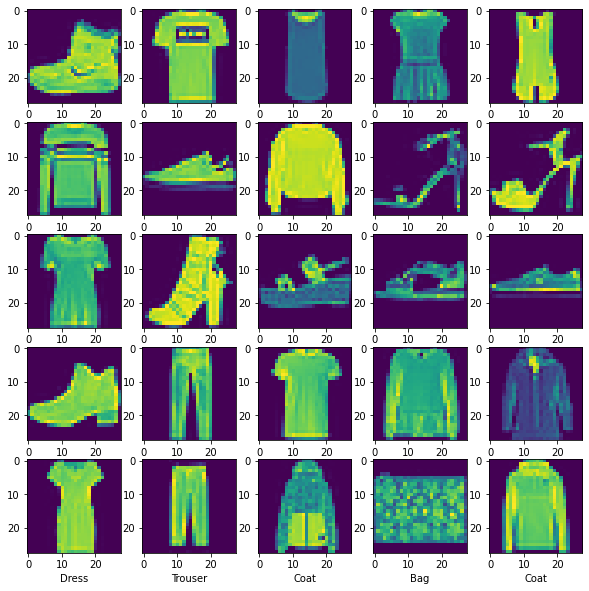

In [15]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(LABEL_NAME__[train_labels[i]])
plt.show()

### 데이터 전처리

- #### 정규화

In [17]:
# 0에서 255사이의 값을 갖는 훈련/테스트 데이터들을 0.0~1.0 사이의 값을 갖도록 변환
train_images, test_images = train_images / 255.0, test_images / 255.0

- #### reshape

In [18]:
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)
print(train_images.shape, len(train_labels), train_labels[:5])
print(test_images.shape, len(test_labels), test_labels[:5])

(60000, 28, 28, 1) 60000 [9 0 0 3 0]
(10000, 28, 28, 1) 10000 [9 2 1 1 6]


- #### Encoding

In [20]:
# 원-핫 인코딩 1차원 -> 2차원
train_labels_cate = to_categorical(train_labels, NUM_CLASSES__)
test_labels_cate = to_categorical(test_labels, NUM_CLASSES__)

print(train_labels_cate.shape)
print(train_labels_cate[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### CNN Model build & Fit

In [21]:
input_shape = (28, 28, 1) # (width, height, channel 수)
model = Sequential( [
            Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, kernel_size=(3, 3), activation="relu"),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation="relu"),
            Dropout(0.5),
            Dense(NUM_CLASSES__, activation="softmax")
            ] )

# OneHotEncoding을 안했을 시 loss = spase_categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [22]:
# 모델 저장 폴더
if not os.path.exists("./model"):
    os.mkdir('./model')

filepath = "./model/{epoch:02d}{val_loss:.3f}.h5"

checkpnt = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True)
estop = EarlyStopping(monitor="val_loss", patience=4)

In [23]:
fit_res = model.fit(train_images, train_labels_cate, callbacks=[checkpnt, estop], batch_size=128, validation_split=0.1, epochs=10)

Epoch 1/10
422/422 [==============================] - 43s 98ms/step - loss: 0.9795 - accuracy: 0.6568 - val_loss: 0.4121 - val_accuracy: 0.8490
Epoch 2/10
422/422 [==============================] - 36s 86ms/step - loss: 0.4589 - accuracy: 0.8365 - val_loss: 0.3471 - val_accuracy: 0.8660
Epoch 3/10
422/422 [==============================] - 35s 84ms/step - loss: 0.3795 - accuracy: 0.8618 - val_loss: 0.3159 - val_accuracy: 0.8810
Epoch 4/10
422/422 [==============================] - 36s 85ms/step - loss: 0.3454 - accuracy: 0.8766 - val_loss: 0.3022 - val_accuracy: 0.8833
Epoch 5/10
422/422 [==============================] - 34s 82ms/step - loss: 0.3213 - accuracy: 0.8821 - val_loss: 0.2856 - val_accuracy: 0.8953
Epoch 6/10
422/422 [==============================] - 34s 81ms/step - loss: 0.2992 - accuracy: 0.8924 - val_loss: 0.2791 - val_accuracy: 0.8948
Epoch 7/10
422/422 [==============================] - 26s 61ms/step - loss: 0.2909 - accuracy: 0.8947 - val_loss: 0.2663 - val_accuracy:

313/313 [==============================] - 3s 8ms/step - loss: 0.2697 - accuracy: 0.9029
loss: 0.26968 accuracy: 0.90290


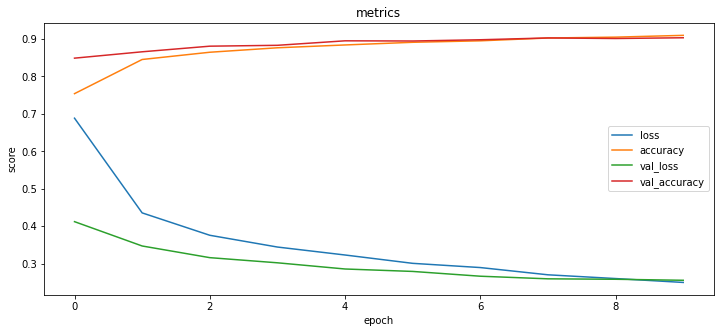

In [25]:
myscore(test_images,  test_labels_cate, fit_res)

### 이미지 증강(Augmentation)
#### Keras ImageDataGenerator <br>
ref : https://www.kaggle.com/parulpandey/overview-of-popular-image-augmentation-packages
ref : https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
ref : https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

* Flipping 
  This means flipping the image horizontally or vertically
* Rotation 
  This means to rotate the image by a given angle in the clockwise or anticlockwise direction
* Cropping 
  During cropping, a section of the image is sampled randomly
* Brightness 
  Increase or decrease the brightness of the image
* Scaling
  Scaling Images can be scaled outward or inward. When scaled outward, the image size increases while the image size decreases when scaled inwards.
* Noise Addition
  We can also add gaussian noise to the existing images.

In [26]:
# Keras
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img 

(28, 28, 1)


(-0.5, 27.5, 27.5, -0.5)

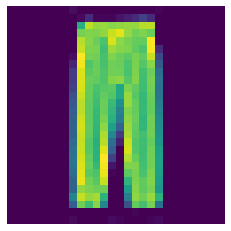

In [27]:
image5 = train_images[21]
plt.imshow(image5)
print(image5.shape)
plt.axis('off')

In [28]:
# 증강 이미지 저장 폴더
import os
if not os.path.exists("./img_aug"):
    os.mkdir('./img_aug')

### 좌우 회전 (horizontal flip)

In [31]:
# Augmentation process
datagen = ImageDataGenerator (
            rotation_range = 40,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            brightness_range = (0.5, 1.5)
        )

img_arr = img_to_array(image5)
img_arr = img_arr.reshape((1,) + img_arr.shape)

i=0
for batch in datagen.flow(
                        img_arr,
                        batch_size = 1,
                        save_to_dir = './img_aug',
                        save_prefix = 'aug_',
                        save_format = 'png'):
    i += 1
    if i > 20:
        break

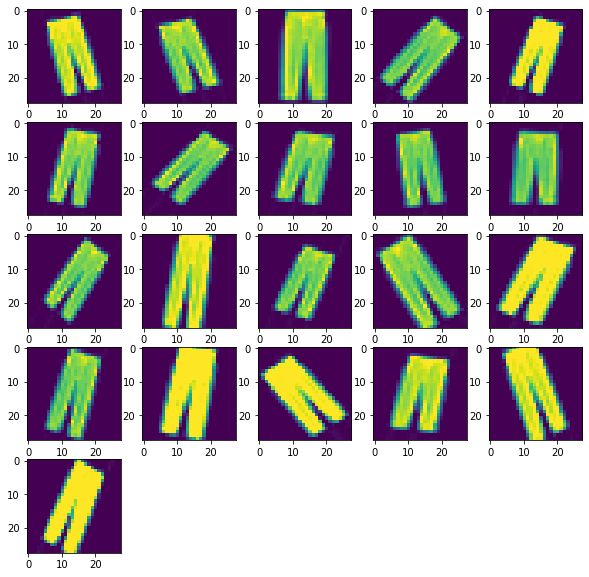

In [32]:
import matplotlib.image as mpimg
import glob

aug_images = []
for img_path in glob.glob("./img_aug/*.png"):
    aug_images.append(mpimg.imread(img_path))

columns = 5   
plt.figure(figsize=(10,10))
for i, image in enumerate(aug_images):
    plt.subplot(len(aug_images) / columns + 1, columns, i + 1)
    plt.imshow(image)